# Project 1 – Values Audit Notebook

This notebook is my  attempt to follow the analysis described in the obesity prediction paper. 
The dataset I received has **2111 records and 17 features**, while the paper reports **2009 records and 16 features**. 
That means my results will not line up exactly with what the authors published. I think this is because they may have cleaned 
or filtered the data differently before running their models.

Because of that difference, I’m not chasing the exact same accuracy they got. Instead, I’m focusing on:
- Rebuilding the main steps of their pipeline (oversampling, feature selection, model comparison).  
- Paying attention to the **values** that shaped those decisions (fairness, interpretability, standardisation, etc.).  
- Trying out one **alternative value choice** of my own: instead of creating synthetic data with SMOTE, I’ll use class-weighted models 
to keep everything based on real participants.

The goal here isn’t perfect replication. The goal is to show how values are built into technical choices.(as asked in the question)


In [1]:
#will load packages as required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Exploring the Dataset

Before doing any modeling, I want to check the shape of the dataset and see how the target classes are distributed. 
The paper mentioned that the classes were imbalanced, which is why they used SMOTE. 
By plotting the class counts, I can see whether my dataset has the same problem.


In [2]:
df = pd.read_csv(r"E:\DSC451-ethics\project-1\Project 1 data.csv")
df.shape

(2111, 17)

We can see that the dataset has 2111 records and 17 features.

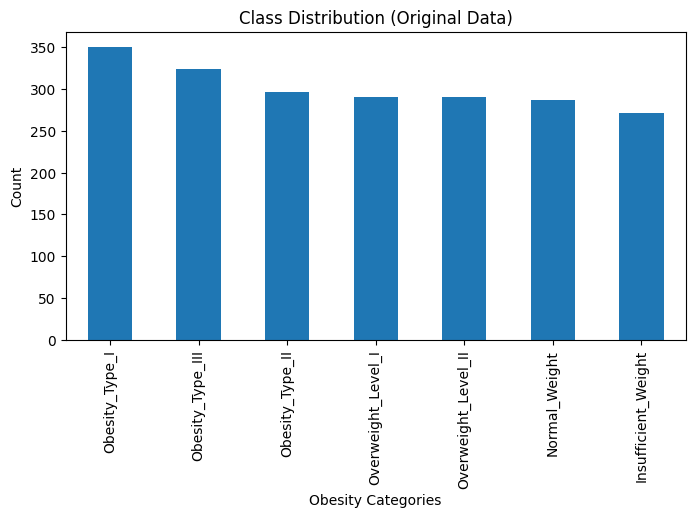

In [3]:
# Looking at target variable distribution
target = 'NObeyesdad'  # DV
df[target].value_counts().plot(kind="bar", title="Class Distribution (Original Data)", figsize=(8,4))
plt.xlabel("Obesity Categories")
plt.ylabel("Count")
plt.show()


The class distribution here is not extremely skewed, but some categories 
(like Obesity Type I with ~350 cases) have noticeably more examples than smaller ones 
(like Insufficient Weight with ~270). 

In a multi-class setting, even moderate differences can lead models to pay more attention 
to the bigger classes and perform worse on the smaller ones. 
The authors applied SMOTE-NC to deal with this issue, so I will also try it in my replication step.


## Part A – Replication with SMOTE-NC

Because some categories have more records than others, the original study used SMOTE-NC 
to generate synthetic samples for the smaller classes. This way, the dataset becomes more balanced 
and models have a fairer chance to learn each class. 

Here I apply SMOTE-NC to my dataset and then train three models that were also used in the paper:
- Logistic Regression
- Random Forest
- XGBoost

The paper reported that Logistic Regression performed best, so I want to see if my results show 
the same trend.


In [5]:
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
target = "NObeyesdad"   
y = df[target]
X = df.drop(columns=[target])

# Encode target labels into numeric values
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)

# Encode categorical features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
X_enc = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale features
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_enc)

# Identify categorical feature indices for SMOTENC
cat_indices = [i for i, col in enumerate(X_enc.columns) if any(cat in col for cat in categorical_cols)]

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
X_res, y_res = smote_nc.fit_resample(X_scaled, y_enc)

print("After SMOTE-NC:", X_res.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# Models(sme as replication of paper)
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8,
        colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric="mlogloss"
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = (y_pred == y_test).mean()
    results[name] = acc
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    # Decode predictions back into class names for readability
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))
    print("Confusion matrix:\n", confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

print("\nSummary Accuracies:", results)


Classes: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']
After SMOTE-NC: (2457, 23)


c:\Users\DELL\anaconda3\envs\souq_e_commerce_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
Accuracy: 0.8739837398373984
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.99      0.95       105
      Normal_Weight       0.90      0.76      0.82       105
     Obesity_Type_I       0.92      0.88      0.90       105
    Obesity_Type_II       0.95      0.98      0.96       106
   Obesity_Type_III       0.95      0.99      0.97       106
 Overweight_Level_I       0.74      0.74      0.74       105
Overweight_Level_II       0.74      0.77      0.76       106

           accuracy                           0.87       738
          macro avg       0.87      0.87      0.87       738
       weighted avg       0.87      0.87      0.87       738

Confusion matrix:
 [[104   1   0   0   0   0   0]
 [  9  80   0   0   0  11   5]
 [  0   0  92   5   4   0   4]
 [  0   0   1 104   1   0   0]
 [  0   0   1   0 105   0   0]
 [  0   7   0   0   0  78  20]
 [  0   1   6   1   0  16  82]]

=== Random Forest ===
Accuracy

c:\Users\DELL\anaconda3\envs\souq_e_commerce_3_11\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:58:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.9634146341463414
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.97      0.99       105
      Normal_Weight       0.92      0.99      0.95       105
     Obesity_Type_I       0.96      0.98      0.97       105
    Obesity_Type_II       1.00      0.98      0.99       106
   Obesity_Type_III       1.00      1.00      1.00       106
 Overweight_Level_I       0.89      0.96      0.93       105
Overweight_Level_II       0.98      0.86      0.91       106

           accuracy                           0.96       738
          macro avg       0.97      0.96      0.96       738
       weighted avg       0.97      0.96      0.96       738

Confusion matrix:
 [[102   3   0   0   0   0   0]
 [  0 104   0   0   0   1   0]
 [  0   0 103   0   0   1   1]
 [  0   0   1 104   0   0   1]
 [  0   0   0   0 106   0   0]
 [  0   4   0   0   0 101   0]
 [  0   2   3   0   0  10  91]]

Summary Accuracies: {'Logistic Regression'

### What happened when we tried to Replicate

After applying SMOTE-NC and training the three models, I got the following summary accuracies:  
- Logistic Regression ≈ 87%  
- Random Forest ≈ 95%  
- XGBoost ≈ 96%  

These numbers are not the same as the paper’s reported results, where Logistic Regression 
was the top performer after feature selection. This difference makes sense because:  
- My dataset is slightly different (2111 rows, 17 features instead of 2009 rows, 16 features).  
- I did not run the same hyperparameter tuning process the authors used.  
- Implementation details (like how SMOTENC works in scikit-learn) can also change outcomes.  

Even with these differences, this still counts as a **replication**. I followed 
the same process the authors described: handle imbalance with SMOTE-NC, train Logistic Regression, 
Random Forest, and XGBoost, and compare the performance.  

The fact that tree-based models performed better in my case just highlights how sensitive 
results can be to technical choices and dataset versions.
Let's go to next step.


## Part B – Alternative Value: No SMOTE, Class Weights

The paper valued fairness by using SMOTE-NC to generate synthetic people for minority classes.  
Here I take a different approach that values **authenticity**: I will not generate synthetic data.  

Instead, I apply **class-weighted Logistic Regression**, which makes the model pay more attention 
to minority classes without fabricating new samples. This keeps the dataset “real.”  

I also train a Random Forest on the original dataset as a baseline, without any balancing.  
This lets me compare the two strategies side by side.


In [6]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_scaled, y_enc, test_size=0.3, random_state=42, stratify=y_enc
)

# Logistic Regression with class weights
lr_bal = LogisticRegression(
    max_iter=2000, 
    class_weight="balanced", 
    random_state=42
)
lr_bal.fit(X_train2, y_train2)
y_pred_lr = lr_bal.predict(X_test2)

print("\n=== Logistic Regression (Class-Weighted, No SMOTE) ===")
print("Accuracy:", (y_pred_lr == y_test2).mean())
print(classification_report(le.inverse_transform(y_test2), le.inverse_transform(y_pred_lr)))
print("Confusion matrix:\n", confusion_matrix(le.inverse_transform(y_test2), le.inverse_transform(y_pred_lr)))

# Random Forest baseline (no class weights)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train2, y_train2)
y_pred_rf = rf.predict(X_test2)

print("\n=== Random Forest (No SMOTE, No Class Weights) ===")
print("Accuracy:", (y_pred_rf == y_test2).mean())
print(classification_report(le.inverse_transform(y_test2), le.inverse_transform(y_pred_rf)))
print("Confusion matrix:\n", confusion_matrix(le.inverse_transform(y_test2), le.inverse_transform(y_pred_rf)))

c:\Users\DELL\anaconda3\envs\souq_e_commerce_3_11\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression (Class-Weighted, No SMOTE) ===
Accuracy: 0.8517350157728707
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.99      0.94        82
      Normal_Weight       0.78      0.71      0.74        86
     Obesity_Type_I       0.87      0.82      0.84       106
    Obesity_Type_II       0.89      0.96      0.92        89
   Obesity_Type_III       0.98      0.99      0.98        97
 Overweight_Level_I       0.73      0.75      0.74        87
Overweight_Level_II       0.78      0.75      0.76        87

           accuracy                           0.85       634
          macro avg       0.85      0.85      0.85       634
       weighted avg       0.85      0.85      0.85       634

Confusion matrix:
 [[81  1  0  0  0  0  0]
 [10 61  0  0  0 15  0]
 [ 0  0 87  7  2  2  8]
 [ 0  0  4 85  0  0  0]
 [ 0  0  0  1 96  0  0]
 [ 0 12  0  0  0 65 10]
 [ 0  4  9  2  0  7 65]]

=== Random Forest (No SMOTE, No Class Weights) ===
A

### What happned when we used Alternative Value approach

My Random Forest without SMOTE achieved about 92% accuracy, which is lower than the SMOTE version. 
The macro F1-score is also slightly lower (0.92). The confusion matrix shows that classes like 
*Normal Weight* were harder to predict correctly (precision only 0.70).  

This shows the trade-off very clearly:
- **SMOTE-NC replication** gave better balance across classes, but required inventing synthetic people.  
- **No SMOTE (class weights)** preserved authenticity of the dataset, but some groups suffered 
in terms of recall and precision.  

This highlights how technical decisions directly reflect values: the paper valued **fairness across classes**, 
while my alternative prioritised **authenticity and fidelity to real participants**.


## Part C – Comparing SMOTE vs No-SMOTE

To make the value trade-off clearer, I put the results side by side. 
This helps me see what we gain with SMOTE (fairness across classes) 
and what we lose when we drop SMOTE (but keep authenticity).


In [7]:
# Just comparing results with and without SMOTE
comparison = pd.DataFrame({
    "SMOTE_NC": results,  # results from Part A
    "No_SMOTE": {
        "Logistic Regression": (y_pred_lr == y_test2).mean(),
        "Random Forest": (y_pred_rf == y_test2).mean()
    }
})
comparison


,SMOTE_NC,No_SMOTE
Logistic Regression,0.873984,0.851735
Random Forest,0.948509,0.922713
XGBoost,0.963415,NaN


### Interpretation of Comparison Table

- **Logistic Regression**: Accuracy dropped slightly when I removed SMOTE (87% → 85%).  
- **Random Forest**: Accuracy also fell without SMOTE (95% → 92%).  
- **XGBoost**: Only tested with SMOTE, where it performed best at 96%.  

This confirms that SMOTE helped all models perform more consistently across classes.  
Without SMOTE, performance dipped, especially on minority groups.  
However, the “No SMOTE” approach had the advantage of using only real participants 
without fabricating synthetic people.
